In [2]:
library(Rtsne)
library(openxlsx)
library(tidyverse)
library(mgsub) # mapping
library(ggplot2)
library(ggrepel)#text
library(scales)

In [3]:
# Organize relationship score
regions = c(
    # English
    'USA','UK','Australia','South Africa',
    # Germany
    'Germany',
    # Japanese
    'Japan',
    # Hebrew
    'Israel',
    # Chinese
    'CHN','HK(region)',

    # French
    'France',
    # Spanish
    'Spain','Mexico','Chile',
    # Portuguese
    'Portugal','Brazil',
    # Russian
    'Russia',
    # Arabic
    'Egypt','Qatar',
    'India')

# Import data

In [4]:
file_path = '../../../DataCleanPCA/output_data/cleaning_results/'


raw_data_list = list()
for (region in dir(file_path)[-which(dir(file_path)=='ReadMe.txt')]){
    file = paste(file_path,region,sep='')
    file = paste(paste(file,'/',sep=''),region,sep='')
    file = paste(file,'_dim_rel_scaled.csv',sep='')
    raw_df = read.csv(file,row.names=1)
    
    region = gsub('HK','HK(region)',region) 
    region = gsub('South_africa','South Africa',region)
    raw_data_list[[region]] = raw_df}

mapping = read.csv('../../../../Study2/input_data/Rel_labels/labels_different_versions.csv',
                  row.names=1)
rdm_list = list()
for (region in regions){
    region_raw_data = raw_data_list[[region]]
    rdm = data.frame(as.matrix(dist(region_raw_data,
                             method = 'euclidean')))
    relationships = rownames(rdm)
    relationships_simple = mgsub(relationships,mapping$'one',mapping$'common')
    
    rownames(rdm) = relationships_simple
    colnames(rdm) = relationships_simple
    rdm_list[[region]] = rdm}

In [5]:
scores_var=read.csv('../../../DataCleanPCA/input_data/Nations/Total/pca_results/Total_scores_var_5c_33d.csv',
                     row.names=1)
colnames(scores_var) = c('Activeness','Exchange','Formality','Equality','Valence')
scores_var['Activeness'] = -scores_var['Activeness']
scores_var['Formality'] = -scores_var['Formality']
scores_var['Valence'] = -scores_var['Valence']
rownames(scores_var) = mgsub(rownames(scores_var),mapping$'one',mapping$'common')

# Formality_max = max(scores_var$'Formality')
# Formality_min = min(scores_var$'Formality')
# Formality_mid = (Formality_max+Formality_min)/2

# Activeness_max = max(scores_var$'Activeness')
# Activeness_min = min(scores_var$'Activeness')
# Activeness_mid = (Activeness_max+Activeness_min)/2

# Find neighbors of Neighbor

In [6]:
# pick up the most similar relations to the "Neighbors"
neighbors_near_rdm = list()
for (region in regions){
    rdm = rdm_list[[region]]
    near_rel = rownames(rdm %>% arrange(Neighbors) 
                        %>% select('Neighbors') %>% head(16)) #the first is the neighbor itself
    near_rdm = rdm[near_rel,near_rel]
    neighbors_near_rdm[[region]] = near_rdm}

In [7]:
CHN_near = rownames(neighbors_near_rdm[['CHN']])
USA_near = rownames(neighbors_near_rdm[['USA']])
Israel_near = rownames(neighbors_near_rdm[['Israel']])

union_near = union(union(CHN_near,USA_near),Israel_near)

In [8]:
union_near

[1] "Neighbors"                         "Fraternity brothers"              
 [3] "Peers"                             "Alumni"                           
 [5] "Guest-Host"                        "Classmates"                       
 [7] "Fans of the same sports team"      "Sorority sisters"                 
 [9] "Childhood friends"                 "Step siblings"                    
[11] "Roommates"                         "Half siblings"                    
[13] "Second cousins"                    "Cousins"                          
[15] "Distant relatives"                 "A person and their family friends"
[17] "Student-Dorm Resident assistant"   "Victim-Witness"                   
[19] "A monarch and their minister"      "Driver-Passenger"                 
[21] "Predecessor-Successor"             "Native-Tourist"                   
[23] "Police officer-Civilian"           "Nurse-Patient"                    
[25] "A person and their in laws"        "Casual acquaintances"             
[27] "Church members"                    "Facebook friends"                 
[29] "Playmates"                         "Co-workers"                       
[31] "Pen-friends"                       "Principal-Teacher"                
[33] "Director-Performer"

In [9]:
scores_var_union = scores_var %>% filter(rownames(scores_var)%in%union_near)
Formality_max = max(scores_var_union$'Formality')
Formality_min = min(scores_var_union$'Formality')
Formality_mid = (Formality_max+Formality_min)/2

Activeness_max = max(scores_var_union$'Activeness')
Activeness_min = min(scores_var_union$'Activeness')
Activeness_mid = (Activeness_max+Activeness_min)/2

# t-SNE

## Local

### Formality

In [10]:
# use t-sne to reduce the 33D into 2-D
tsne_dim_local_formality = function(region,near_rdm=neighbors_near_rdm[[region]],
                    full_rdm=rdm_list[[region]],perplexity=15,xadjust=0,yadjust=0,
                    max.iter = 10000){
    Formality_min = -1.5
    Formality_mid = 0
    Formality_max = 1.5
    
    set.seed(2023)
    # t-SNE for all 159 relationships
    region_tsne = Rtsne(full_rdm,perplexity = perplexity)
    region_tsne_plot = data.frame(region_tsne$'Y')
    rownames(region_tsne_plot) = rownames(full_rdm)
    
    # find neighbors of "neighbors"
    neighbors = rownames(near_rdm)
    neighbors = neighbors[-which(neighbors=='Neighbors')]
    region_tsne_plot = region_tsne_plot %>% mutate(stress=case_when(
                            rownames(region_tsne_plot)%in%neighbors~'1',
                            rownames(region_tsne_plot)%in%c('Neighbors')~'2',
                            TRUE~'0'))
    
    # add dimensional score
    region_tsne_plot = cbind(region_tsne_plot,scores_var)
    
    neighbors_plot = region_tsne_plot %>% filter(stress=='1')
    itself_plot = region_tsne_plot %>% filter(stress=='2')
    
    # zoom
    xrange = region_tsne_plot %>% filter(stress=='1') %>% 
                                  summarize(x_min = min(X1),x_max = max(X1))
    xlow = xrange$'x_min'
    xup = xrange$'x_max'

    yrange = region_tsne_plot %>% filter(stress=='1') %>% 
                                  summarize(y_min = min(X2),y_max = max(X2))
    ylow = yrange$'y_min'
    yup = yrange$'y_max'

    # Plot results
    options(repr.plot.width=10,repr.plot.height=10)
    ggplot(itself_plot,aes(x=X1+xadjust,y=X2+yadjust,label=rownames(itself_plot)))+
    # 1.stress Neighbor
    geom_text(size=18,fontface = 'bold')+
    # 2.map color into neighbors of Neighbor
    geom_text_repel(data=neighbors_plot,aes(x=X1,y=X2,color=Formality,
                    label=rownames(neighbors_plot)),size=18,max.iter = max.iter)+
    scale_color_gradientn(colours = c("#B2182B","#FDDBC7","#2166AC"),
                      values = rescale(c(Formality_min,Formality_mid,Formality_max)),
                      guide = "colorbar", limits=c(Formality_min,Formality_max))+
    
    xlim(xlow,xup)+
    ylim(ylow,yup)+
    #ggtitle(region)+
    theme_classic()+
    theme(axis.title=element_blank(),plot.title = element_text(size=30,hjust = 0.5),
          axis.text=element_blank(),axis.ticks = element_blank(),
          axis.line.x=element_line(linetype=1,color="white",size=3),
          axis.line.y=element_line(linetype=1,color="white",size=3),
          legend.position='none')}

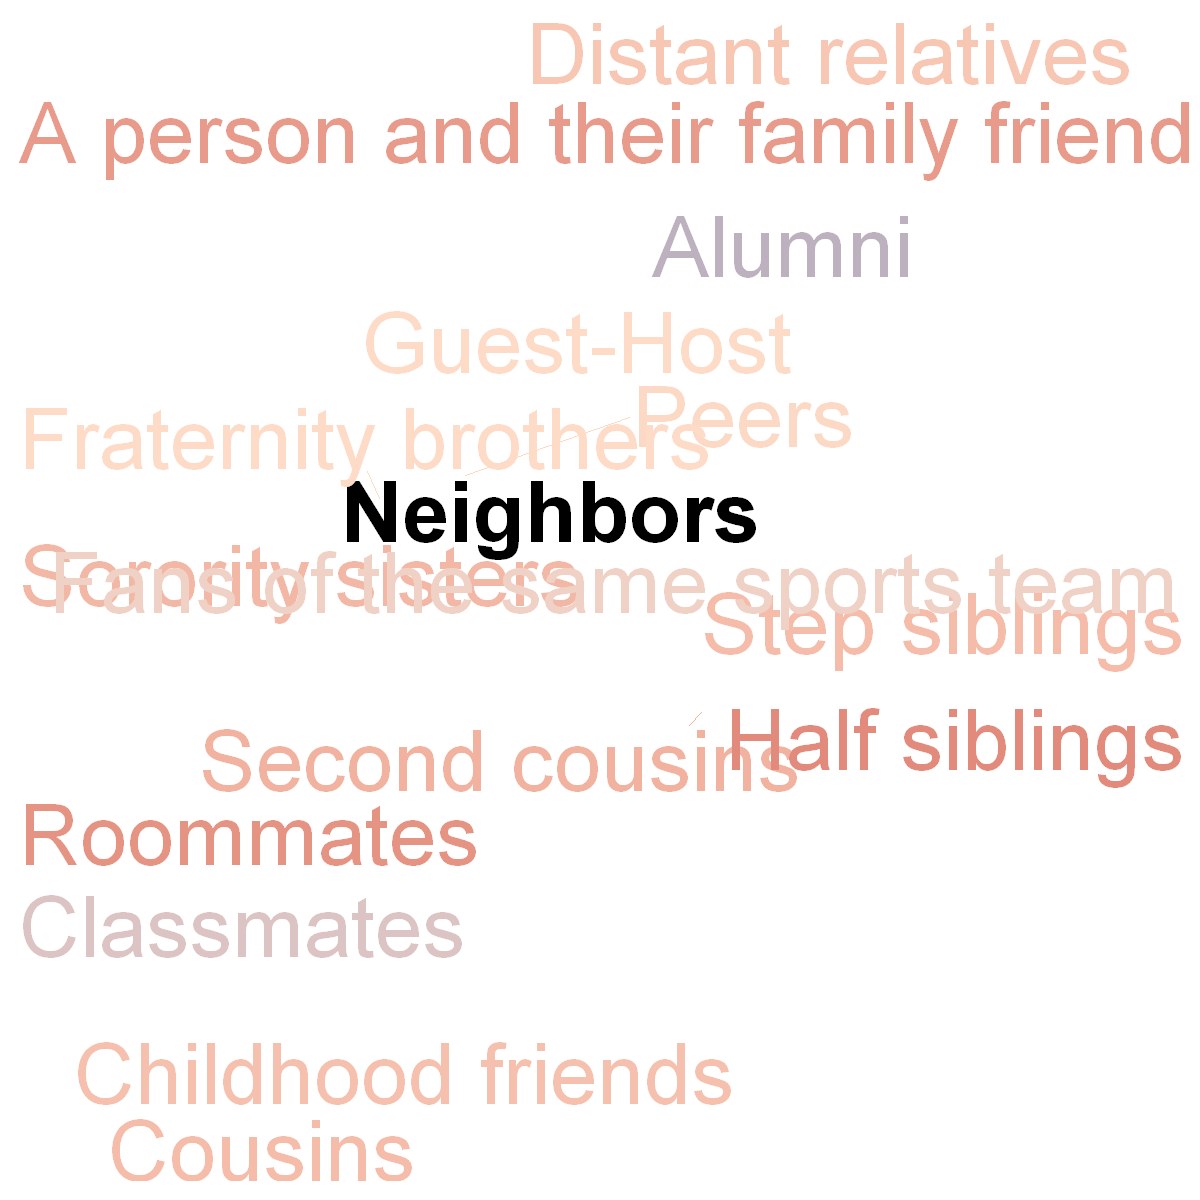

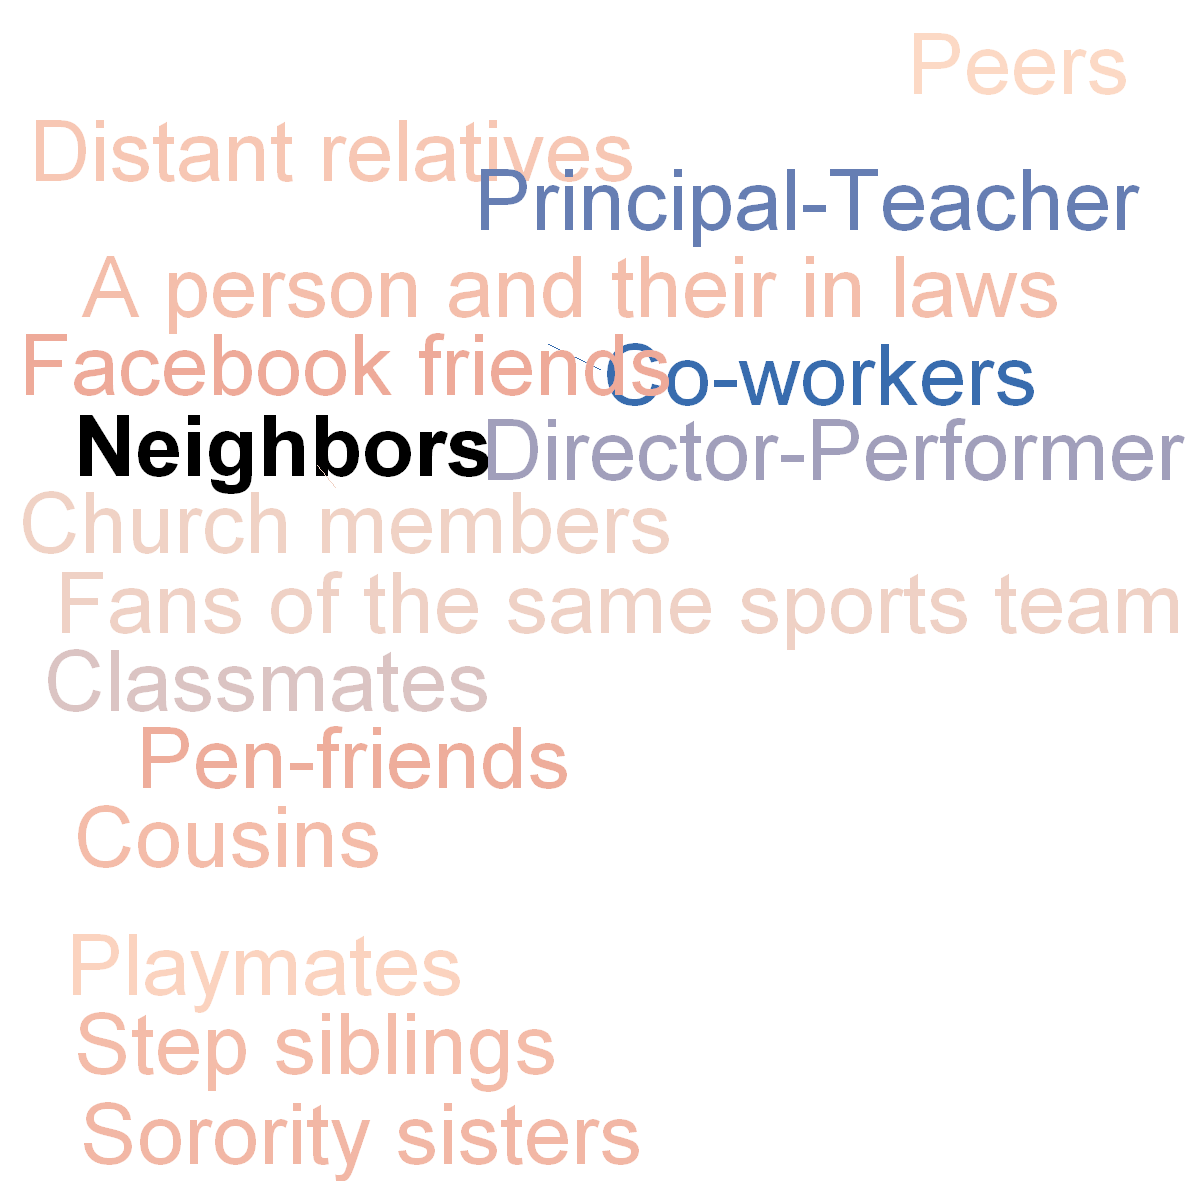

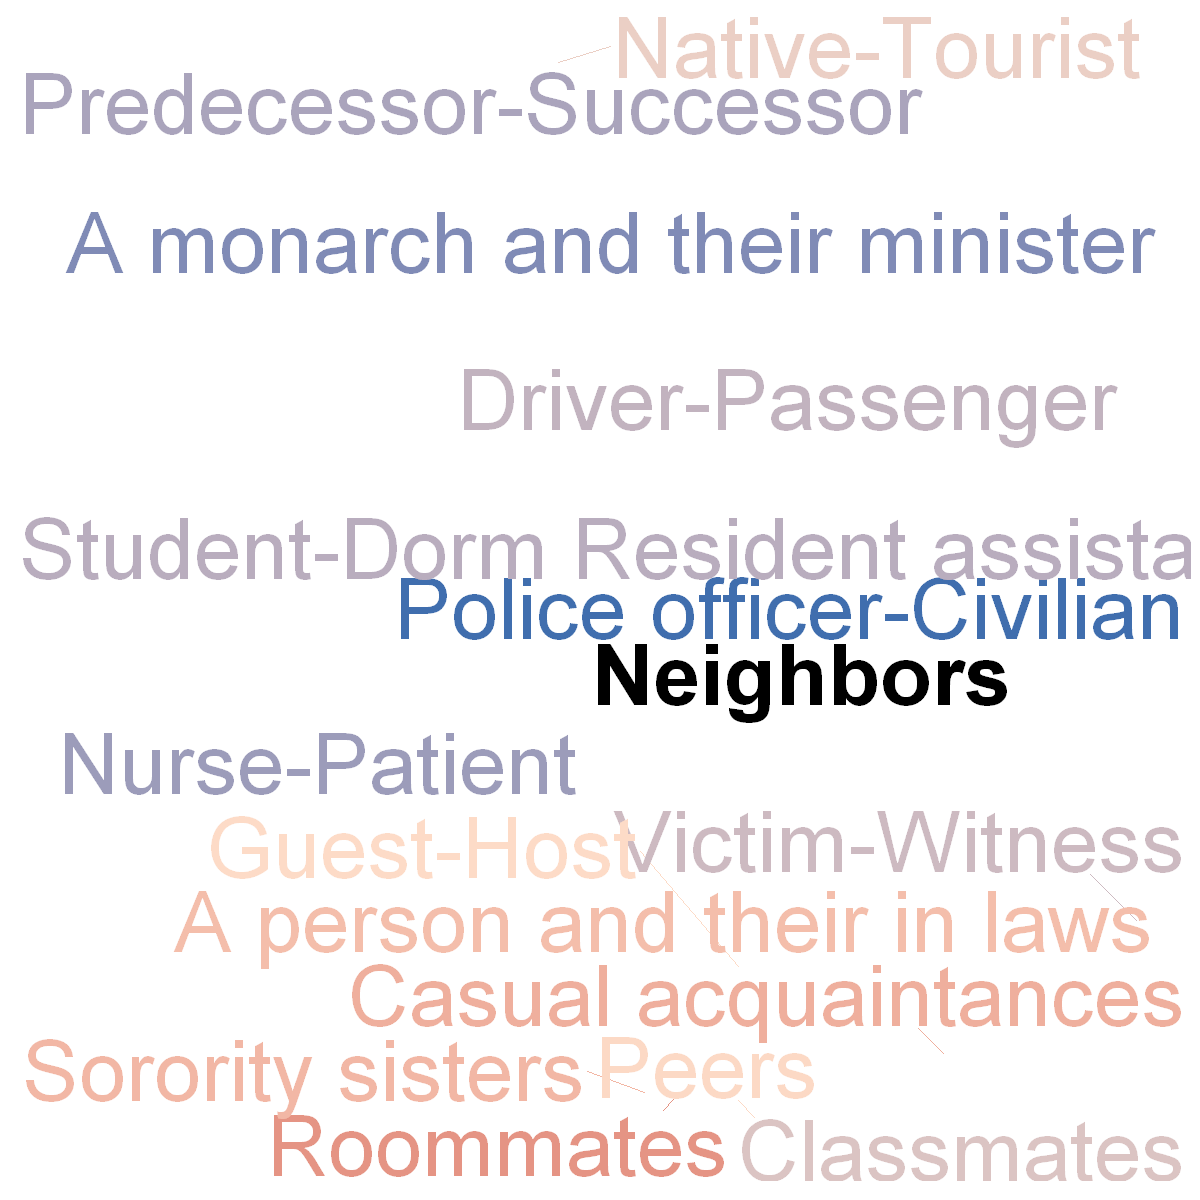

In [33]:
region = 'CHN'
tsne_dim_local_formality(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],perplexity=8,xadjust=0,yadjust=-0.8,max.iter = 10000)

region = 'Israel'
tsne_dim_local_formality(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],perplexity=11,xadjust=-0.4,yadjust=0.5,max.iter=10000)

region = 'USA'
tsne_dim_local_formality(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],perplexity=8)

In [11]:
Formality_min
Formality_max

[1] -0.6735003

[1] 1.41824

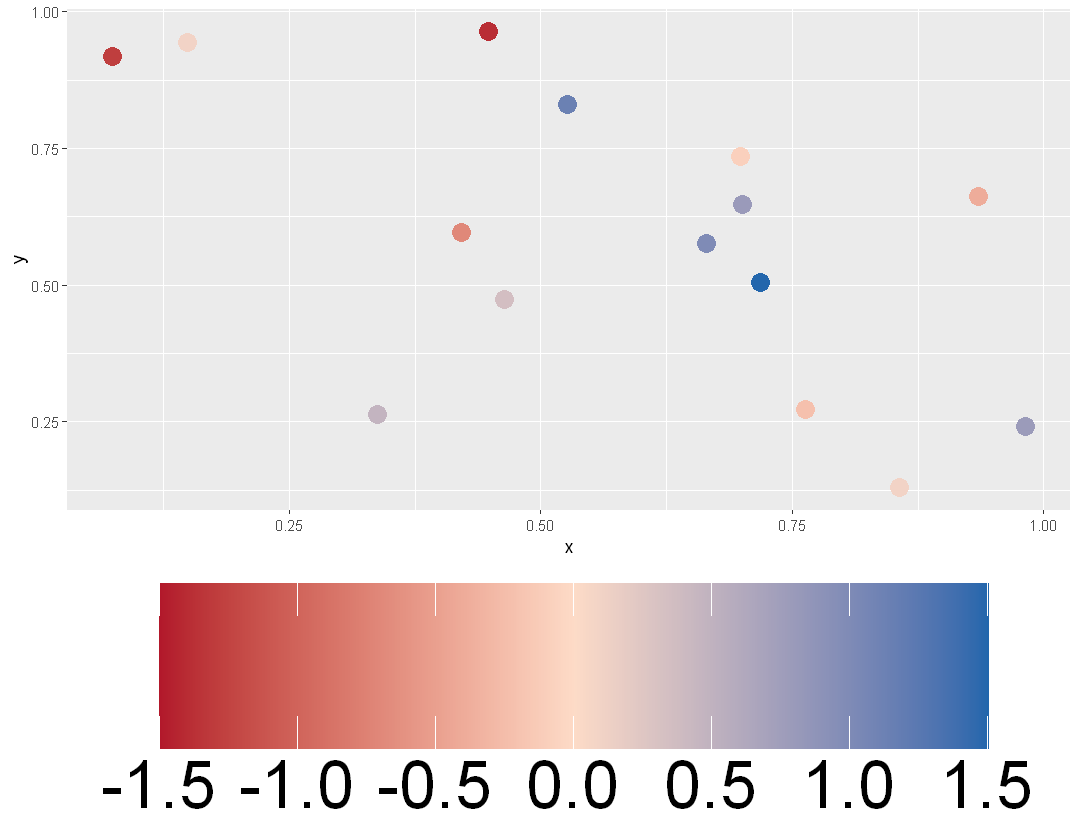

In [19]:
options(repr.plot.width=9)
df <- data.frame(x = runif(15),y = runif(15),
                 z = runif(15,-1.5,1.5))
ggplot(df,aes(x,y,color=z))+
geom_point(size=5)+
scale_color_gradientn(colours = c("#B2182B","#FDDBC7","#2166AC"),
                      values = rescale(c(-1.5,0,1.5)),
                      guide = "colorbar", limits=c(-1.5,1.5))+
theme(legend.position = 'bottom',
      legend.title = element_blank(),
      legend.text=element_text(size=40),
      legend.key.size = unit(100,'pt'))

## Global

In [21]:
# use t-sne to reduce the 33D into 2-D
tsne_dim_global = function(region,near_rdm=neighbors_near_rdm[[region]],
                    full_rdm=rdm_list[[region]],perplexity=15,width,height){
    set.seed(2023)
    # t-SNE for all 159 relationships
    region_tsne = Rtsne(full_rdm,perplexity = perplexity)
    region_tsne_plot = data.frame(region_tsne$'Y')
    rownames(region_tsne_plot) = rownames(full_rdm)
    
    # find neighbors of "neighbors"
    neighbors = rownames(near_rdm)
    neighbors = neighbors[-which(neighbors=='Neighbors')]
    region_tsne_plot = region_tsne_plot %>% mutate(stress=case_when(
                            rownames(region_tsne_plot)%in%neighbors~'1',
                            rownames(region_tsne_plot)%in%c('Neighbors')~'2',
                            TRUE~'0'))
    
    # Plot results
    options(repr.plot.width=width,repr.plot.height=height)
    ggplot(region_tsne_plot,aes(x=X1,y=X2,color=stress))+
    scale_color_manual(values=c('1'='#7F7F7F','0'='black','2'='red'))+
    geom_point(size=4)+
    #ggtitle(region)+
    theme_classic()+
    theme(axis.title=element_blank(),plot.title = element_text(size=30,hjust = 0.5),
          axis.text=element_blank(),axis.ticks = element_blank(),
          axis.line.x=element_line(linetype=1,color="black",size=3),
          axis.line.y=element_line(linetype=1,color="black",size=3),
          legend.position='none')
}

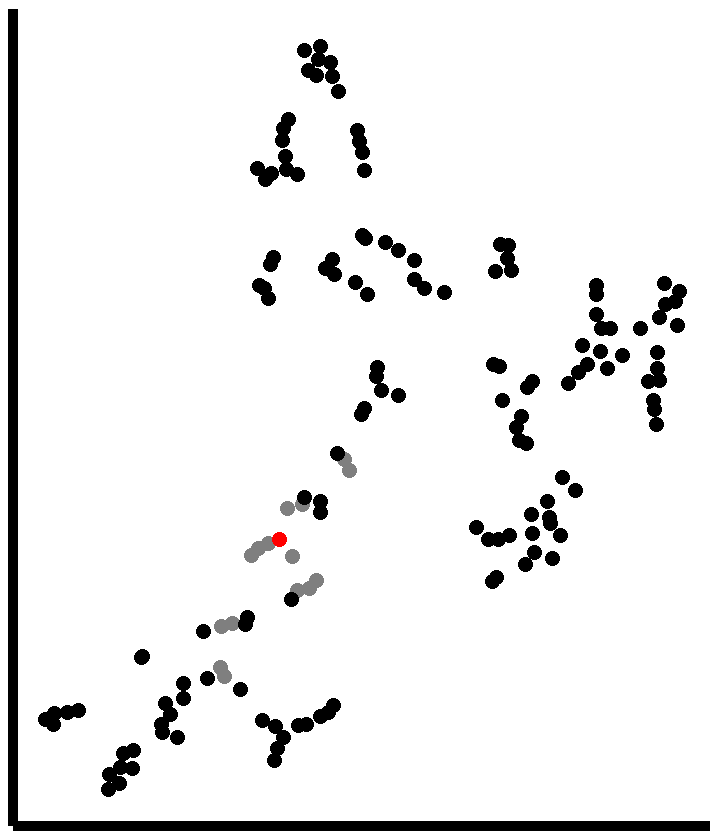

In [22]:
region = 'CHN'
tsne_dim_global(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],8,width=6,height=7)

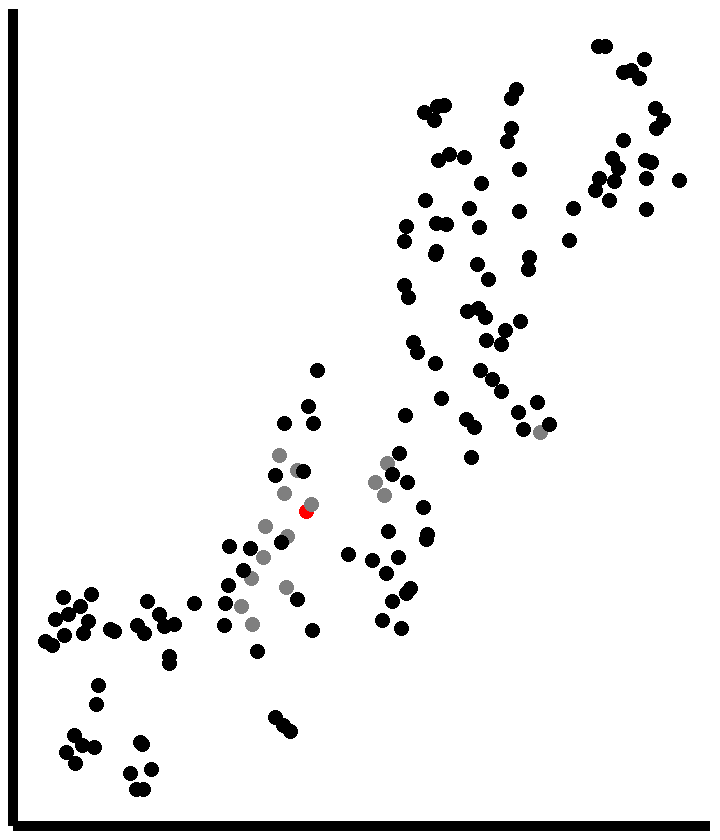

In [23]:
region = 'Israel'
tsne_dim_global(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],11,width=6,height=7)

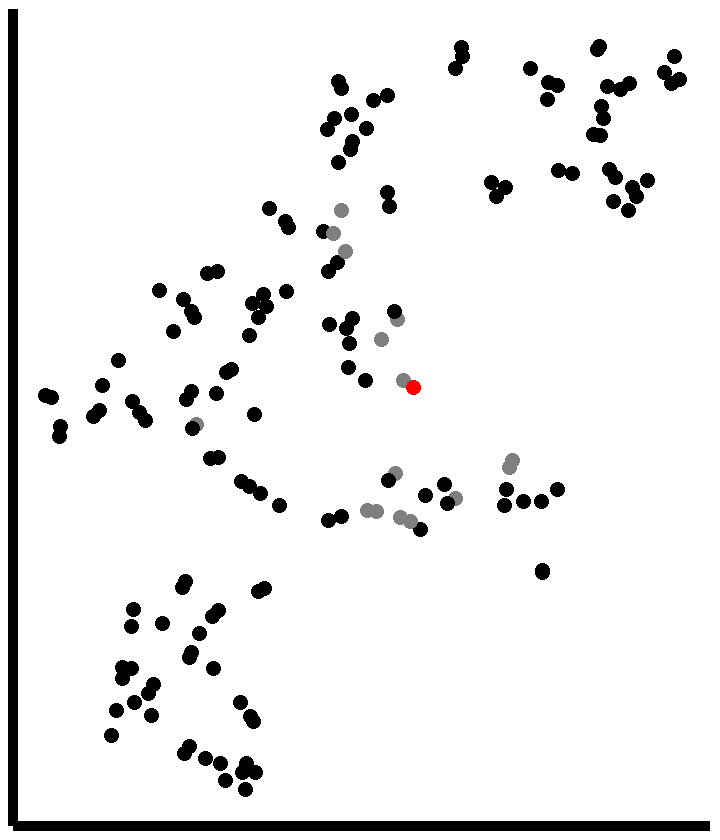

In [24]:
region = 'USA'
tsne_dim_global(region,near_rdm=neighbors_near_rdm[[region]],
         full_rdm=rdm_list[[region]],8,width=6,height=7)